# Import libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Metric
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer

# Model
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Tuning
from sklearn.model_selection import GridSearchCV

In [2]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

# Data field

- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

# Information and Description

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


# Drop features (casual, registered)
- In train dataset, casual and registered features can't use training
- Two feature are not included test dataset

In [5]:
df_train.drop(columns=['casual', 'registered'], inplace=True)

# Check Null data

In [6]:
df_train.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
count         0
dtype: int64

# Processing datetime

In [7]:
df_train['datetime'] = pd.to_datetime(df_train['datetime'])
df_test['datetime'] = pd.to_datetime(df_test['datetime'])

In [8]:
df_train = df_train.assign(
    year = df_train['datetime'].dt.year,
    month = df_train['datetime'].dt.month,
    hour = df_train['datetime'].dt.hour,
    weekday = df_train['datetime'].dt.weekday
)

In [9]:
df_test = df_test.assign(
    year = df_test['datetime'].dt.year,
    month = df_test['datetime'].dt.month,
    hour = df_test['datetime'].dt.hour,
    weekday = df_test['datetime'].dt.weekday
)

# Visualize dataset for analysis

## Draw distibution plot for `count`
 - The count variable is skewed to the left. If the regression model is used, it is recommended to change it to a normal distribution form.

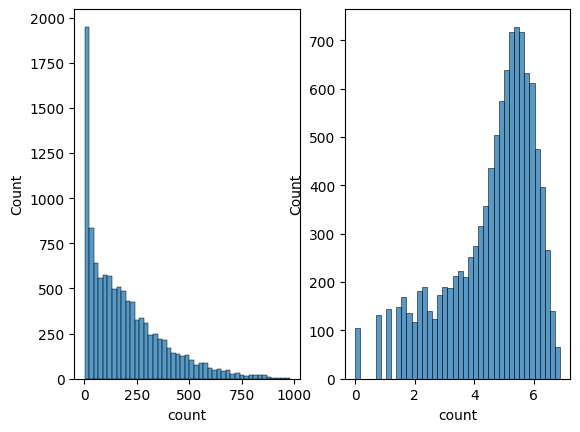

In [10]:
fig, axes = plt.subplots(1,2)
sns.histplot(df_train['count'], ax = axes[0])
sns.histplot(np.log(df_train['count']), ax = axes[1])
plt.show()

## Draw bike usage by year, month, hour, weekday, holiday, season
### Year
- Bike rental usage increased in 2012 compared to 2011.

### Season
- In seasons 2 and 3, the number of rentals increased, increased from April to September, and although October to December decreased slightly, the utilization rate is higher than that of January to March.
- It seems to be more accurate to understand monthly than Season.

### Holiday
- The rentals count is similar when it is shared and when it is not. Further analysis of outliers is needed.

### Month
- January has the lowest number of users and June has the highest number of users. As winter passes, the number of users increases, and when the weather gets cold, the number of users decreases again.

### Hour
- As expected, there are fewer uses in the early morning hours. It is mainly used during the daytime, and it can be seen that it is used especially during commuting hours.

### Working day
- It doesn't seem to have much to do with working days. It looks like a bicycle rental, regardless of the working day.

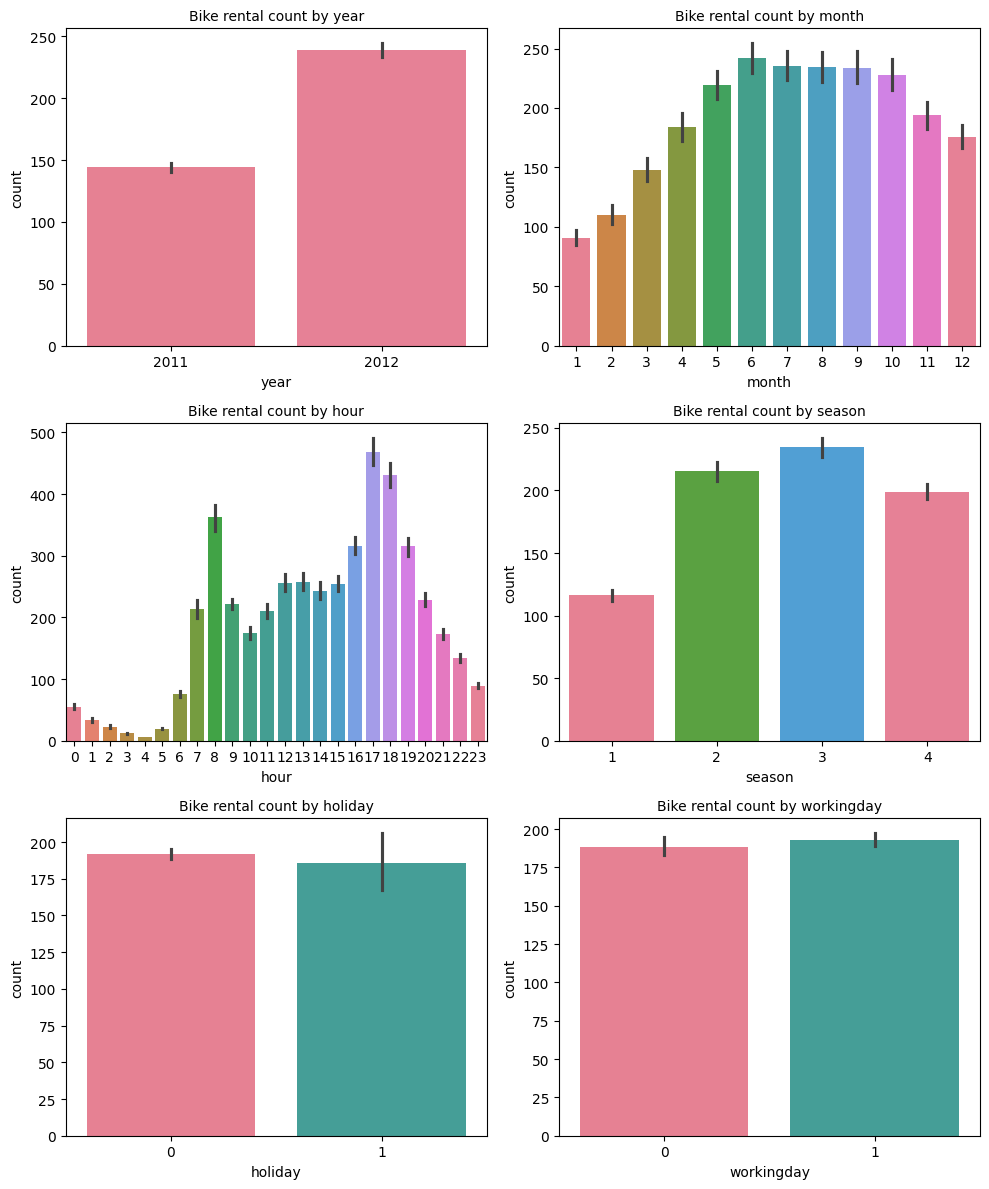

In [11]:
fig_row = 3
fig_col = 2

mpl.rc('font', size = 10)
mpl.rc('axes', titlesize = 10)

fig, axes = plt.subplots(fig_row, fig_col)
fig.set_size_inches(10, 12)

draw_cols = ['year', 'month', 'hour', 'season', 'holiday', 'workingday']
for idx, col in enumerate(draw_cols):
    ax = axes[int(idx / fig_col)][int(idx % fig_col)]
    sns.barplot(df_train, x = col, y = 'count',
                ax = ax,
                palette='husl', hue = col)
    ax.set_title('Bike rental count by {}'.format(col))
    ax.legend().remove()
plt.tight_layout()
plt.show()

## Draw box-plot by season, weather, holiday, workingday 

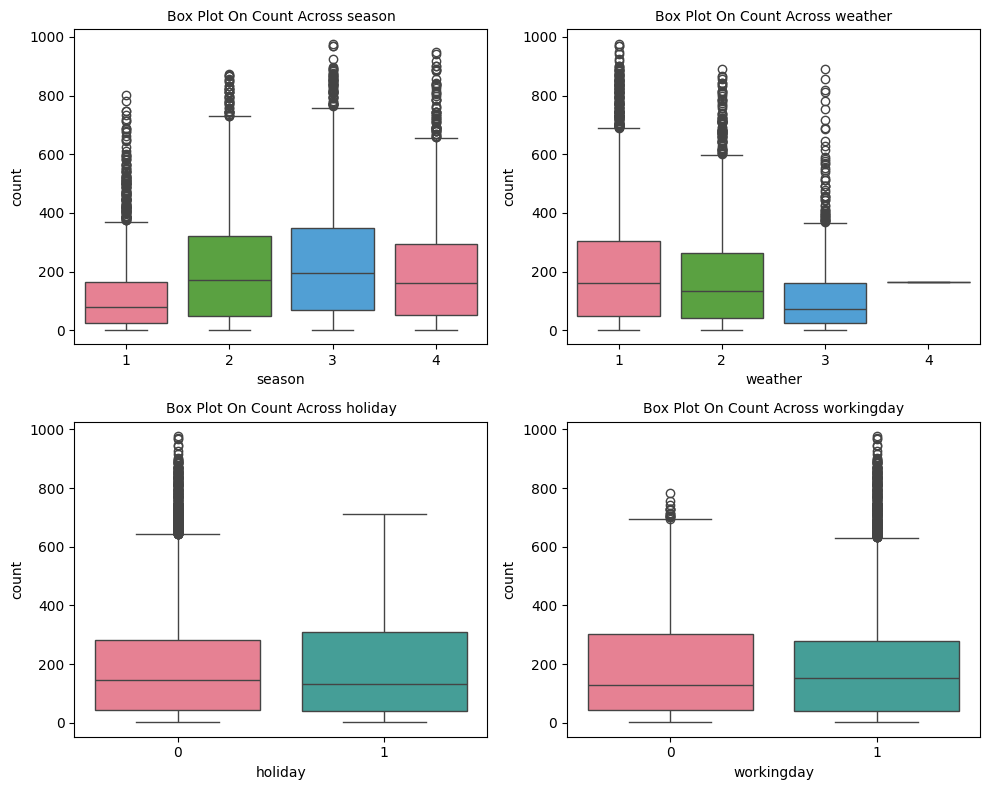

In [12]:
fig_row = 2
fig_col = 2

mpl.rc('font', size = 10)
mpl.rc('axes', titlesize = 10)

fig, axes = plt.subplots(fig_row, fig_col)
fig.set_size_inches(10, 8)

draw_cols = ['season', 'weather', 'holiday', 'workingday']
for idx, col in enumerate(draw_cols):
    ax = axes[int(idx / fig_col)][int(idx % fig_col)]
    sns.boxplot(df_train, x = col, y = 'count',
                ax = ax,
                palette='husl', hue = col)
    ax.set_title('Box Plot On Count Across {}'.format(col))
    ax.legend().remove()
plt.tight_layout()
plt.show()

## Draw point-plot by season, weather, holiday, workingday
- Overall, there are a lot of costs during rush hour. However, on days other than working days, it seems that it is most frequently rented from 10 a.m. to 5 p.m., not during rush hour.
- Based on this plot, it can be seen that Working day and hour are important variables in predicting the number of rentals.

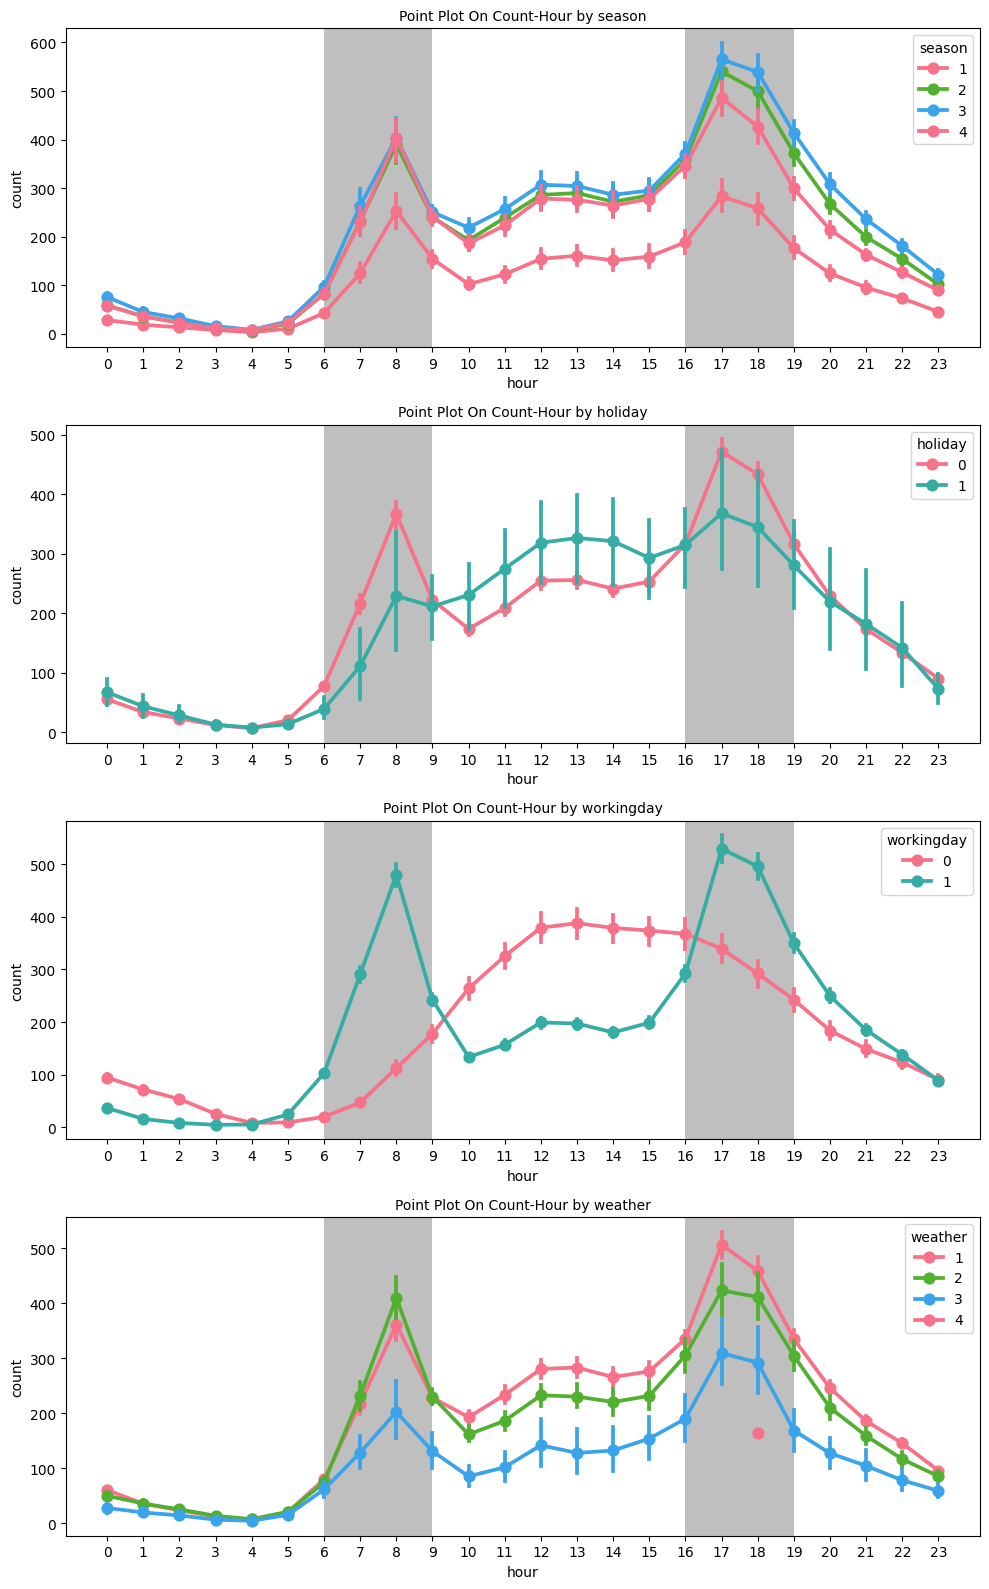

In [13]:
fig_row = 4
fig_col = 1

mpl.rc('font', size = 10)
mpl.rc('axes', titlesize = 10)

fig, axes = plt.subplots(fig_row, fig_col)
fig.set_size_inches(10, 16)

draw_cols = ['season', 'holiday', 'workingday', 'weather']
for idx, col in enumerate(draw_cols):
    ax = axes[idx]
    sns.pointplot(df_train, x = 'hour', y = 'count',
                ax = ax,
                palette='husl', hue = col)
    ax.set_title('Point Plot On Count-Hour by {}'.format(col))
    ax.axvspan(6,9, facecolor = 'gray', alpha = 0.5)
    ax.axvspan(16,19, facecolor = 'gray', alpha = 0.5)
plt.tight_layout()
plt.show()

## Draw regplot
- The Windspeed variable has too many values of zero. It is necessary to consider whether to exclude it with the wrong value.

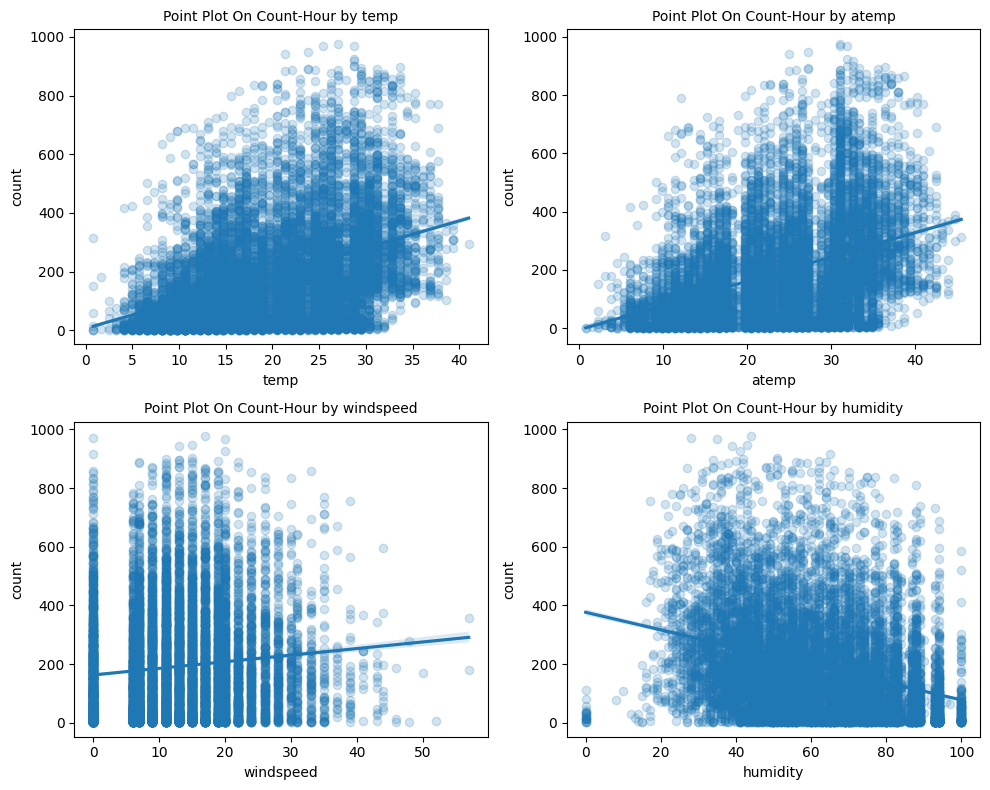

In [14]:
fig_row = 2
fig_col = 2

mpl.rc('font', size = 10)
mpl.rc('axes', titlesize = 10)

fig, axes = plt.subplots(fig_row, fig_col)
fig.set_size_inches(10, 8)

draw_cols = ['temp', 'atemp', 'windspeed', 'humidity']
for idx, col in enumerate(draw_cols):
    ax = axes[int(idx / fig_col)][int(idx % fig_col)]
    sns.regplot(df_train, x = col, y = 'count',
                ax = ax, scatter_kws={'alpha' : 0.2})
    ax.set_title('Point Plot On Count-Hour by {}'.format(col))
plt.tight_layout()
plt.show()

# PreProcessing

## Outlier

In [15]:
df_train = df_train.loc[df_train.weather != 4].reset_index(drop=True)

## Missing value

In [16]:
df_train = df_train.loc[df_train.windspeed != 0].reset_index(drop=True)

## One Hot Encoding

In [17]:
df_train = pd.get_dummies(df_train, columns = ['season', 'weather'], dtype = int, drop_first=True)
df_test = pd.get_dummies(df_test, columns = ['season', 'weather'], dtype = int, drop_first=True)

## Split train and testset

In [18]:
train, test = train_test_split(df_train, test_size = 0.3, stratify=df_train['workingday'], random_state=42)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [19]:
train.workingday.value_counts()

workingday
1    4556
0    2144
Name: count, dtype: int64

In [20]:
test.workingday.value_counts()

workingday
1    1953
0     919
Name: count, dtype: int64

# Modeling

## 0) Prepare modeling

In [21]:
df_train.columns

Index(['datetime', 'holiday', 'workingday', 'temp', 'atemp', 'humidity',
       'windspeed', 'count', 'year', 'month', 'hour', 'weekday', 'season_2',
       'season_3', 'season_4', 'weather_2', 'weather_3'],
      dtype='object')

In [22]:
x_cols = ['holiday', 'workingday', 'temp', 'atemp', 'humidity',
       'windspeed', 'year', 'hour', 'weekday', 'season_2',
       'season_3', 'season_4', 'weather_2', 'weather_3']
y_col = 'count'

In [23]:
def rmsle_scorer(y_true, y_pred):
    y_pred = np.exp(y_pred)
    y_true = np.exp(y_true)
    return mean_squared_log_error(y_true, y_pred, squared=True)

## 1) XGBoost Regressor

In [24]:
xgb_grid_params = {
    'n_estimators' : [120, 140, 160],
    'alpha' : [0.01, 0.05, 0.1],
    'max_depth' : [5, 7, 9]
}

In [25]:
xgb_grcv = GridSearchCV(
    estimator = XGBRegressor(random_state = 42),
    param_grid = xgb_grid_params,
    scoring = make_scorer(rmsle_scorer, greater_is_better=False),
    cv = 5,
    n_jobs = -1
).fit (train[x_cols], np.log(train[y_col]))

In [26]:
xgb_pred = xgb_grcv.predict(test[x_cols])
mean_squared_log_error(test[y_col], np.exp(xgb_pred), squared=True)

0.0926993174378812

## 2) RandomForest

In [27]:
rf_grid_params = {
    'n_estimators' : [100, 120, 140],
}

In [28]:
rf_grcv = GridSearchCV(
    estimator = RandomForestRegressor(random_state=42),
    param_grid = rf_grid_params,
    scoring = make_scorer(rmsle_scorer, greater_is_better=False),
    cv = 5,
    n_jobs = -1
).fit (train[x_cols], np.log(train[y_col]))

In [29]:
rf_pred = rf_grcv.predict(test[x_cols])
mean_squared_log_error(test[y_col], np.exp(rf_pred), squared=True)

0.10412157148058752

## 3) Sum predict

In [30]:
y_pred = np.exp(xgb_pred) * 0.7 + np.exp(rf_pred) * 0.3
mean_squared_log_error(test[y_col], y_pred, squared=True)

0.08693580416502157

# Result

# Predict test dataset

In [31]:
xgb_pred = xgb_grcv.predict(df_test[x_cols])
rf_pred = rf_grcv.predict(df_test[x_cols])

In [36]:
df_test['count'] = np.exp(xgb_pred) * 0.5 + np.exp(rf_pred) * 0.5
df_submission = df_test[['datetime', 'count']]

## Save submission

In [37]:
df_submission.to_csv('submission.csv', index=False)